### Classifier from embeddings

In [1]:
%reload_ext autoreload
%autoreload 2

import sys, os
# if "../../.." not in sys.path:
#     sys.path.append("../../..")
proj = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
if proj not in sys.path:
    sys.path.insert(0, proj)

In [2]:
# Device independent code
import torch

device = "cpu" 
if torch.cuda.is_available():
    device = "cuda"
# if torch.backends.mps.is_available:
#     device = torch.device("mps")
torch.device(device)
torch.set_default_device(device=device)

os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

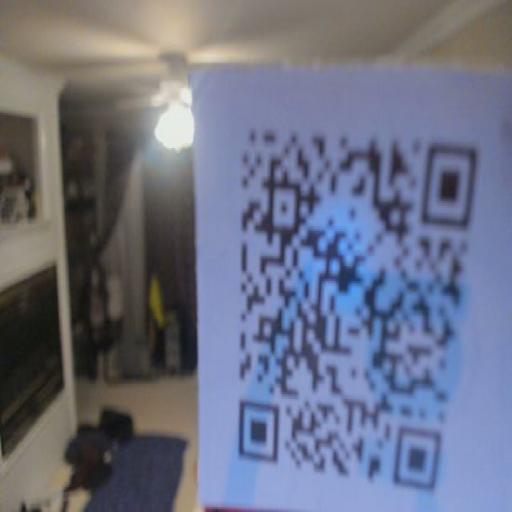

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=512x512>,
 'mask': <PIL.PngImagePlugin.PngImageFile image mode=L size=512x512>,
 'category': 'qrcode'}

Dataset({
    features: ['image', 'mask', 'category'],
    num_rows: 16351
})

In [9]:
from dataset import get_categories_train_dataset
dataset = get_categories_train_dataset()
display(dataset[0]["image"])
display(dataset[0])
display(dataset)

In [13]:
from dataset import get_qrcode_train_dataset, get_barcode_train_dataset

qrcode_dataset_train = get_qrcode_train_dataset()
barcode_dataset_train = get_barcode_train_dataset()
qrcode_dataset_train, barcode_dataset_train

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/22 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/21 [00:00<?, ?it/s]

(Dataset({
     features: ['image', 'mask', 'bbox', 'label', 'category'],
     num_rows: 502
 }),
 Dataset({
     features: ['image', 'label', 'ocr', 'category', 'mask'],
     num_rows: 15849
 }))

In [ ]:
example, example1 = qrcode_dataset_train[0], qrcode_dataset_train[1]
display(example["image"]) 
display(example["label"])
display(example["bbox"])
display(example1["image"])
display(example1["label"])
display(example1["bbox"])

#### Train Classifier

In [11]:
import pandas as pd
df = pd.DataFrame(dataset[600:800])
df

,image,mask,category
0,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
1,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
2,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
3,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
4,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
...,...,...,...
195,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
196,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
197,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode
198,<PIL.PngImagePlugin.PngImageFile image mode=RG...,None,barcode


In [31]:
import torch
from tqdm.notebook import tqdm
import numpy as np
import json

from datasets import Dataset
from dataset.product import lookup_product
from dataset.ingestion import Ingestor
from dataset.models.dinov2_hf_model import model, processor
import pandas as pd

cursor = None
ingestor = Ingestor(cursor, model=model, processor=processor, device=device)

def compute_embeddings(dataset: Dataset) -> dict:
    """
    Create an index that contains all of the images in the specified list of files.
    """
    all_embeddings = []
    
    with torch.inference_mode():
      embeddings_and_categories = [(ingestor.embedding(image=entry["image"]).cpu().tolist(), entry["category"]) for i, entry in enumerate(tqdm(dataset.iter(batch_size=1)))]
      all_embeddings, categories = zip(*embeddings_and_categories)

    with open("all_embeddings.json", "w") as f:
        f.write(json.dumps(all_embeddings))

    # labels = [label for i in all_embeddings]

    return all_embeddings, categories

In [32]:
# TODO multiple labels
embeddings, labels = compute_embeddings(dataset.select(range(500, 600)))

0it [00:00, ?it/s]

In [28]:
f"{len(embeddings)}*{len(embeddings[0])} vs {len(labels)}", embeddings[0]

('100*768 vs 100',
 [3.337815999984741,
  0.23661191761493683,
  0.009934534318745136,
  -1.4432417154312134,
  0.6553225517272949,
  0.48477739095687866,
  -0.8620080947875977,
  -0.5308129787445068,
  -0.38485726714134216,
  0.7159401774406433,
  1.2704843282699585,
  -1.5023123025894165,
  0.7858227491378784,
  -2.2826263904571533,
  1.4532204866409302,
  -0.45766201615333557,
  -0.5140377283096313,
  -0.60634446144104,
  -1.7125697135925293,
  0.004018790554255247,
  0.6505781412124634,
  -2.191436767578125,
  0.5655714273452759,
  -0.3878985047340393,
  -0.4143217206001282,
  -2.1086859703063965,
  -1.130206823348999,
  0.4119340181350708,
  -2.30251145362854,
  1.1681281328201294,
  0.06377720087766647,
  -0.9555473923683167,
  -1.4076504707336426,
  0.7327247858047485,
  -1.038565754890442,
  -1.0691888332366943,
  -1.4155378341674805,
  1.5850372314453125,
  -0.00799629557877779,
  -0.033680498600006104,
  0.42246514558792114,
  -2.991727113723755,
  0.4531535804271698,
  -0.25

### Train Classifier

Training a Support Vector Machine (SVM) classifier on the embeddings of the training data.

See notes in https://python.plainenglish.io/a-comprehensive-guide-to-support-vector-machine-svm-algorithm-76dbcf18b5ae

Consider building out a HybridModel approach based on https://github.com/ameyachawlaggsipu/Hybrid_LLM_Classifier/blob/master/hybrid_model/model.py

In [30]:
from sklearn import svm

# 2. If n is small (1–10 00) and m is intermediate (10–10,000) : use SVM with (Gaussian, polynomial etc) kernel
# - https://medium.com/axum-labs/logistic-regression-vs-support-vector-machines-svm-c335610a3d16
clf = svm.SVC(gamma='scale') #
clf.fit(np.array(embeddings).reshape(-1, 768), labels)

/opt/homebrew/Caskroom/miniconda/base/lib/python3.11/site-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVC()